In [183]:
import json
import pandas as pd
import requests
from IPython.display import display, HTML
import pickle
import string

In [184]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [185]:
# Function to create HTML display
def create_hit_list(data):
    html_content = "<div style='font-family: Arial, sans-serif;'>"
    
    for product in data['hits']:
        source = product['_source']
        title = source['title']
        category = " > ".join(source['category'])
        image_url = source['image']
        
        # Create an HTML card for each product
        html_content += f"""
        <div style='border: 1px solid #ddd; margin: 10px; padding: 10px; width: 300px; display: inline-block; vertical-align: top;'>
            <img src="{image_url}" alt="Product Image" style='width: 100%; height: auto; margin-bottom: 10px; background-color: black;' onerror="this.style.backgroundColor='black'; this.src='';">
            <h4 style='margin: 0; font-size: 16px; color: #333;'>{title}</h4>
            <p style='margin: 5px 0; font-size: 12px; color: #777;'>{category}</p>
        </div>
        """
    
    html_content += "</div>"
    return html_content

In [186]:
# Returns the number of query terms
def get_num_of_terms(query_string):
    terms = query_string.split(" ")
    return len(terms)

# Returns the query length (number of characters)
def get_query_length(query_string):
    return len(query_string)

# Returns 1 in case the query contains one or more numbers, 0 otherwise
def get_has_numbers(query_string):
    return int(any(char.isdigit() for char in query_string))

# Returns 1 in case the query contains one or more special characters, 0 otherwise
def get_has_special_char(query_string):
    # Define special characters (all non-alphanumeric characters)
    special_chars = string.punctuation
    # Return True if any character in the string is a special character
    return int(any(char in special_chars for char in query_string))

In [187]:
# Calculates the features and returns them as an array
def get_features(query):
    num_of_terms = get_num_of_terms(query)
    query_length = get_query_length(query)
    has_numbers = get_has_numbers(query)
    has_special_char = get_has_special_char(query)
    features = [num_of_terms, query_length, has_numbers, has_special_char]
    return features

In [188]:
# Load model
with open('../models/random_forest_model_query_features.pkl', 'rb') as fid:
    random_forest = pickle.load(fid)

In [196]:
# Predict the NDCG for each neuralness value between 0 and 1.0 in steps of 0.1
# Return the neuralness for which the highest 
def get_prediction(features):
    max_prediction = float('-inf')
    best_neuralness = None
    for i in range(11):  # 11 because we need 0 to 10 inclusive
        neuralness = i * 0.1
        # Calculate features
        features.insert(0, neuralness)
        # Predict the value using the model
        prediction = random_forest.predict([features])[0]
        #print(f"NDCG {prediction} for neuralness of {neuralness}")
        if prediction > max_prediction:
            max_prediction = prediction
            best_neuralness = neuralness
        features.pop(0)
    return round(best_neuralness,2)

In [197]:
get_features("iphone 15 - case")

[4, 16, 1, 1]

In [198]:
get_prediction(get_features("iphone 15 case"))

0.6

In [199]:
# Get model_id
# We are assuming that the installation has only one model. Change this if you have more models 
# and need to pick a specific one
headers = {
    'Content-Type': 'application/json'
}

def get_model_id():
    url = "http://localhost:9200/_plugins/_ml/models/_search"
   
    payload = {
      "query": {
        "match_all": {}
      },
      "size": 1
    }
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))

    return response.json()['hits']['hits'][0]['_source']['model_id']

model_id = get_model_id()

In [200]:
model_id

'_Qf5upMBYH7IJQxM0UzC'

In [201]:
# Get the best neuralness score for a query and send the query to OpenSearch with the corresponding
# neuralness and keywordness values
def query_os(query_string):
    url = "http://localhost:9200/ecommerce/_search"
    neuralness = get_prediction(get_features(query_string))
    keywordness = 1 - neuralness
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ],
          "includes": [
              "_id", "image", "title", "category"
          ]
      },
      "query": {
        "hybrid": {
          "queries": [
            {
              "multi_match" : {
                  "type":       "best_fields",
                  "fields":     [
                    "asin^100",
                    "bullets^3",
                    "attrs.Color^2",
                    "attrs.Brand^5",
                    "description",
                    "title^10"
                  ],
                  "operator":   "and",
                  "query":      query_string
                }
            },
            {
              "neural": {
                "title_embedding": {
                  "query_text": query_string,
                  "k": 100
                }
              }
            }
          ]
        }
      },
        "search_pipeline": {
          "request_processors": [
            {
              "neural_query_enricher" : {
                "description": "one of many search pipelines for experimentation",
                "default_model_id": model_id,
                "neural_field_default_id": {
                   "title_embeddings": model_id
                }
              }
            }
          ],
          "phase_results_processors": [
            {
              "normalization-processor": {
                "normalization": {
                  "technique": "l2"
                },
                "combination": {
                  "technique": "arithmetic_mean",
                  "parameters": {
                    "weights": [
                      keywordness,
                      neuralness
                    ]
                  }
                }
              }
            }
          ]    
        },
      "size": 20
    }
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    print(f"Searching with neural weight of {neuralness} and keyword search weight of {round(keywordness,2)}")
    return response

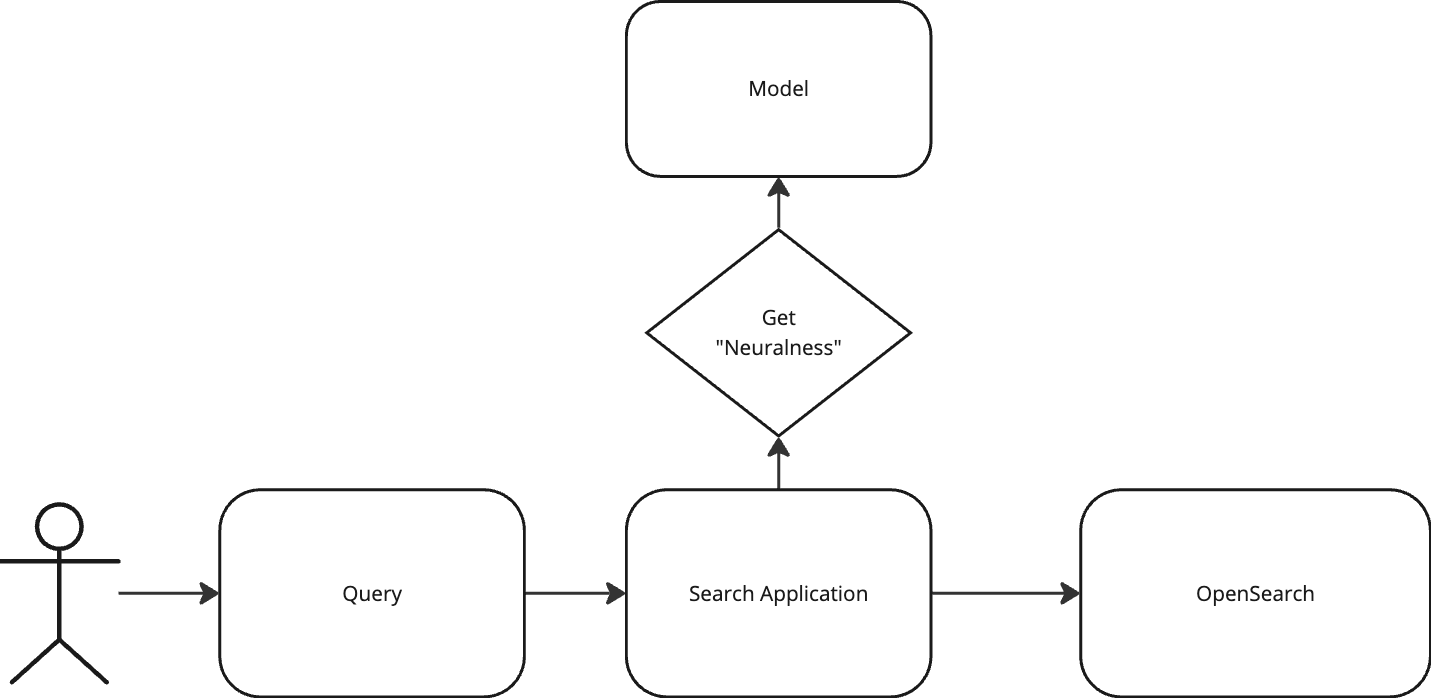

In [204]:
# Display the hit list
response = query_os("ipad case black 10 inchess")
html = create_hit_list(response['hits'])
display(HTML(html))

Searching with neural weight of 0.7 and keyword search weight of 0.3
